## Import required packages

In [1]:
import os  # <- package used to work with system filepaths
import pandas as pd  # <- package used to import and organize data
import numpy as np  # <- package used to import and organize data
import math
import seaborn as sns  # <- package used to plot graphs
from matplotlib import pyplot as plt  # <- another package used to plot graphs
from itertools import cycle  # <- package used to iterate down rows
from ipywidgets import widgets  # <- widget tool to generate button
from IPython.display import display  # <- displays button
from tkinter import Tk, filedialog  # <- Tkinter is a GUI package
from tqdm.notebook import tqdm
import dask.dataframe as dd
import pingouin as pg
from pingouin import ttest
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 50)
print("done step 1")

done step 1


## Set working directory to where the CSV file with experiment data is

In [2]:
os.getcwd()
os.chdir('/Volumes/JosephBSR/Ben_BSR_all')

## Read in the data, check its size and format

In [3]:
TotalConcatenated = pd.read_csv('baseline_output.csv')

print(TotalConcatenated.shape)
print(TotalConcatenated.head())
# print(TotalConcatenated.tail())

(1442158, 20)
   Unnamed: 0  time_bin  worm   time   speed      x      y  angularspeed  \
0           0       4.0   166  3.959  0.1877  24.45  24.12          9.70   
1           1       4.0   242  3.715  0.2145  31.42  36.22         24.75   
2           2       4.0   243  3.803  0.3030  31.27  37.90         17.75   
3           3       4.0   370  3.785  0.2279  21.31  28.89         32.56   
4           4       4.0   462  3.863  0.2375  21.34  34.94          1.20   

   pathlength   kink  bias  curve  dir     crab  length  midline   width  \
0     0.02400  49.30   1.0  33.80  0.0  0.00420  0.9326    1.055  0.2241   
1     0.06700  74.44   1.0  33.16  0.0  0.04553  0.8833    1.083  0.2542   
2     0.06300  48.25   1.0  31.10  0.0  0.03710  0.8670    1.075  0.2340   
3     0.05680  19.78   1.0  33.97  0.0  0.03903  0.8140    0.973  0.2203   
4     0.04565  44.22   1.0  38.34  0.0  0.00857  0.8057    1.011  0.1313   

   morphwidth     area      Strain  
0     0.16750  0.14870  N2_OffFood 

## Get list of strains in the data set

In [4]:
TotalConcatenated_strains = TotalConcatenated.groupby(["Strain", "worm"], as_index=False).mean()
TotalConcatenated_strains[['Genotype', 'Treatment']] = TotalConcatenated_strains['Strain'].str.split('_', 1, expand = True)
TotalConcatenated_strains = TotalConcatenated_strains.dropna()
TotalConcatenated_strains = TotalConcatenated_strains.Genotype.unique()

# print(TotalConcatenated_strains.head())
# print(TotalConcatenated_strains.tail())

print(TotalConcatenated_strains)

all_strains = pd.DataFrame(TotalConcatenated_strains, columns = ['Genotype'])
print(all_strains)

['N2' 'R07G3.8(tm5683)' 'cat-2(e1112)' 'gba-2(tm4623)' 'gba-4(tm3314)'
 'hipr-1(ok1081)' 'igcm-2(ok1527)' 'lfe-2(tm14109)' 'rskd-1(tm4031)'
 'sac-2(ok2743)' 'set-2(ok1484)']
           Genotype
0                N2
1   R07G3.8(tm5683)
2      cat-2(e1112)
3     gba-2(tm4623)
4     gba-4(tm3314)
5    hipr-1(ok1081)
6    igcm-2(ok1527)
7    lfe-2(tm14109)
8    rskd-1(tm4031)
9     sac-2(ok2743)
10    set-2(ok1484)


<ipython-input-4-8788705eab14>:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  TotalConcatenated_strains[['Genotype', 'Treatment']] = TotalConcatenated_strains['Strain'].str.split('_', 1, expand = True)


## Determine the range for which you want to analyze data

In [5]:
start = 100  # <----- set the start time of the range
point = 400  # <----- set the end time of your range

TotalConcatenated_chunked0 = TotalConcatenated[TotalConcatenated["time"] >= start]
TotalConcatenated_chunked = TotalConcatenated_chunked0[TotalConcatenated_chunked0["time"] <= point]

## Find average measures for each worm (across duration of specified range), split 'Strain' column into two

Ex: 'N2_OnFood' becomes 'N2' & 'OnFood'

In [6]:
TotalConcatenated_mean = TotalConcatenated_chunked.groupby(["Strain", "worm"], as_index=False).mean()
TotalConcatenated_mean[['Genotype', 'Treatment']] = TotalConcatenated_mean['Strain'].str.split('_', 1, expand = True)
# print(TotalConcatenated_mean)

# SELECT ONLY NECESSARY COLUMNS
TotalConcatenated_worm_avg_speed = TotalConcatenated_mean[['Genotype', 'Treatment', 'Strain', 'speed']]
print(TotalConcatenated_worm_avg_speed)

            Genotype Treatment                Strain     speed
0                 N2   OffFood            N2_OffFood  0.185660
1                 N2   OffFood            N2_OffFood  0.164772
2                 N2   OffFood            N2_OffFood  0.166971
3                 N2   OffFood            N2_OffFood  0.194481
4                 N2   OffFood            N2_OffFood  0.204429
...              ...       ...                   ...       ...
11446  set-2(ok1484)    OnFood  set-2(ok1484)_OnFood  0.045343
11447  set-2(ok1484)    OnFood  set-2(ok1484)_OnFood  0.089745
11448  set-2(ok1484)    OnFood  set-2(ok1484)_OnFood  0.058583
11449  set-2(ok1484)    OnFood  set-2(ok1484)_OnFood  0.078368
11450  set-2(ok1484)    OnFood  set-2(ok1484)_OnFood  0.063003

[11451 rows x 4 columns]


<ipython-input-6-9c3bb114ecb7>:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  TotalConcatenated_mean[['Genotype', 'Treatment']] = TotalConcatenated_mean['Strain'].str.split('_', 1, expand = True)


## Find average speed measures for each genotype and treatment (across duration of specified range)

In [7]:
TotalConcatenated_avg_speed = TotalConcatenated_worm_avg_speed.groupby(['Strain', 'Treatment', 'Genotype'], as_index = False).mean()
print(TotalConcatenated_avg_speed)
# print(TotalConcatenated_avg_speed['speed'][1])

                     Strain Treatment         Genotype     speed
0                N2_OffFood   OffFood               N2  0.184379
1                 N2_OnFood    OnFood               N2  0.099498
2   R07G3.8(tm5683)_OffFood   OffFood  R07G3.8(tm5683)  0.162167
3    R07G3.8(tm5683)_OnFood    OnFood  R07G3.8(tm5683)  0.074619
4      cat-2(e1112)_OffFood   OffFood     cat-2(e1112)  0.206655
5       cat-2(e1112)_OnFood    OnFood     cat-2(e1112)  0.179703
6     gba-2(tm4623)_OffFood   OffFood    gba-2(tm4623)  0.165796
7      gba-2(tm4623)_OnFood    OnFood    gba-2(tm4623)  0.067302
8     gba-4(tm3314)_OffFood   OffFood    gba-4(tm3314)  0.134118
9      gba-4(tm3314)_OnFood    OnFood    gba-4(tm3314)  0.058023
10   hipr-1(ok1081)_OffFood   OffFood   hipr-1(ok1081)  0.183672
11    hipr-1(ok1081)_OnFood    OnFood   hipr-1(ok1081)  0.086518
12   igcm-2(ok1527)_OffFood   OffFood   igcm-2(ok1527)  0.169181
13    igcm-2(ok1527)_OnFood    OnFood   igcm-2(ok1527)  0.101381
14   lfe-2(tm14109)_OffFo

## Generate dataframe containing only data for N2 and CB1112 for use in speed trace

In [8]:
N2_cat2 = ['N2_OffFood', 'N2_OnFood', 'cat-2(e1112)_OffFood', 'cat-2(e1112)_OnFood']
TotalN2cat2 = TotalConcatenated[TotalConcatenated['Strain'].isin(N2_cat2)]

print(TotalN2cat2.shape)
print(TotalN2cat2.head())

(757750, 20)
   Unnamed: 0  time_bin  worm   time   speed      x      y  angularspeed  \
0           0       4.0   166  3.959  0.1877  24.45  24.12          9.70   
1           1       4.0   242  3.715  0.2145  31.42  36.22         24.75   
2           2       4.0   243  3.803  0.3030  31.27  37.90         17.75   
3           3       4.0   370  3.785  0.2279  21.31  28.89         32.56   
4           4       4.0   462  3.863  0.2375  21.34  34.94          1.20   

   pathlength   kink  bias  curve  dir     crab  length  midline   width  \
0     0.02400  49.30   1.0  33.80  0.0  0.00420  0.9326    1.055  0.2241   
1     0.06700  74.44   1.0  33.16  0.0  0.04553  0.8833    1.083  0.2542   
2     0.06300  48.25   1.0  31.10  0.0  0.03710  0.8670    1.075  0.2340   
3     0.05680  19.78   1.0  33.97  0.0  0.03903  0.8140    0.973  0.2203   
4     0.04565  44.22   1.0  38.34  0.0  0.00857  0.8057    1.011  0.1313   

   morphwidth     area      Strain  
0     0.16750  0.14870  N2_OffFood  

# 8.2 Speed Trace Plot

<Figure size 432x288 with 0 Axes>

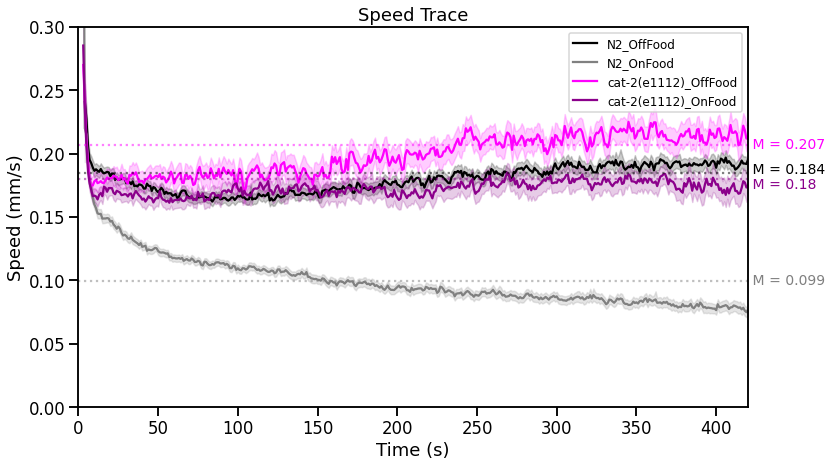

In [9]:
# Setting viewing range for your graph
top = 0.30
bottom = 0
left = 0
right = 420

# Set specifications for graph
sns.set_context("talk")
plt.figure(linewidth = 2.5)
plt.figure(figsize = (12, 7))
plt.gca().xaxis.grid(False)

# Specify data and colours to be used
ax = sns.lineplot(x = "time_bin",
                  y = "speed",
                  # data = TotalConcatenated,  # <----- uncomment and comment row below if using all data
                  data = TotalN2cat2,
                  hue = 'Strain',
                  palette = ['black',
                             'grey',
                             '#FF00FF',
                             '#8B008B',
                             # 'green',  # <----- uncomment additional colours if analyzing more strains (2 per strain)
                             # 'lightgreen',
                             # 'royalblue',
                             # 'lightblue',
                             # '#FFB5C5',
                             # '#CD6889'
                            ])

# Specify labels
plt.xlabel("Time (s)")
plt.ylabel("Speed (mm/s)")
plt.title("Speed Trace")

# Specify viewing range using variables at top of cell
plt.ylim(top = top)
plt.ylim(bottom = bottom)
plt.xlim(left= left)
plt.xlim(right = right)

# Add horizontal lines to visualize mean speed of each strain and condition (comment out if using more than N2 & CB1112)
# If keeping uncommented, may need to adjust indexing to calculate proper speeds
plt.axhline(y = TotalConcatenated_avg_speed['speed'][0], color = 'black', linestyle = ':', alpha = 0.5)
plt.axhline(y = TotalConcatenated_avg_speed['speed'][1], color = 'grey', linestyle = ':', alpha = 0.5)
plt.axhline(y = TotalConcatenated_avg_speed['speed'][4], color = '#FF00FF', linestyle = ':', alpha = 0.5)
plt.axhline(y = TotalConcatenated_avg_speed['speed'][5], color = '#8B008B', linestyle = ':', alpha = 0.5)

# Add annotations to show mean speed of each strain and condition
# Same caution as previous step regarding proper speeds
ax.annotate(f" M = {round(TotalConcatenated_avg_speed['speed'][0], 3)}",
            xy = (420, TotalConcatenated_avg_speed['speed'][0]),
            xytext = (420, TotalConcatenated_avg_speed['speed'][0]),
            color = 'black', size = 14)
ax.annotate(f" M = {round(TotalConcatenated_avg_speed['speed'][1], 3)}",
            xy = (420, TotalConcatenated_avg_speed['speed'][1] - 0.003),
            xytext = (420, TotalConcatenated_avg_speed['speed'][1] - 0.003),
            color = 'grey', size = 14)
ax.annotate(f" M = {round(TotalConcatenated_avg_speed['speed'][4], 3)}",
            xy = (420, TotalConcatenated_avg_speed['speed'][4] - 0.003),
            xytext = (420, TotalConcatenated_avg_speed['speed'][4] - 0.003),
            color = '#FF00FF', size = 14)
ax.annotate(f" M = {round(TotalConcatenated_avg_speed['speed'][5], 3)}",
            xy = (420, TotalConcatenated_avg_speed['speed'][5] - 0.005),
            xytext = (420, TotalConcatenated_avg_speed['speed'][5] - 0.007),
            color = '#8B008B', size = 14)

# Specify location for legend
ax.legend(loc = 'upper right', fontsize = '12'
          # , labels = ['N2 (Off Food)', 'N2 (On Food)', 'CB1112 (Off Food)', 'CB1112 (On Food)']
         )

# Save figure to current working directory
plt.savefig(f'Speed_Trace_{left}to{right}s.jpg', format = 'jpg', dpi = 450)

plt.show()

# BSR bar plot (difference of differences)

### First, take data only from the time in the experiment(s) you want to analyze, and find the average speed for each genotype and treatment

In [10]:
# print(TotalConcatenated.head(1))

start = 100  # <----- set the start time of the range
point = 400  # <----- set the end time of your range

# Take data between specified time points
chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]

# Take mean of all measures for each worm
chunkeddata_mean = chunkeddata.groupby(["Strain", "worm"], as_index = False).mean()

# Split `Strain` column into `Genotype` and `Treatment` columns
chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)

# Select only the specified columns from previous result (others not important for BSR score)
worm_avg_speed = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', 'speed']]

# Take mean speed for each genotype and treatment (should result in 2 rows for each genotype - 1 for each condition)
avg_speed = worm_avg_speed.groupby(["Strain", 'Treatment', 'Genotype'], as_index = False).mean()
print(avg_speed)
# avg_speed.to_csv("avg_speed.csv")

                     Strain Treatment         Genotype     speed
0                N2_OffFood   OffFood               N2  0.184379
1                 N2_OnFood    OnFood               N2  0.099498
2   R07G3.8(tm5683)_OffFood   OffFood  R07G3.8(tm5683)  0.162167
3    R07G3.8(tm5683)_OnFood    OnFood  R07G3.8(tm5683)  0.074619
4      cat-2(e1112)_OffFood   OffFood     cat-2(e1112)  0.206655
5       cat-2(e1112)_OnFood    OnFood     cat-2(e1112)  0.179703
6     gba-2(tm4623)_OffFood   OffFood    gba-2(tm4623)  0.165796
7      gba-2(tm4623)_OnFood    OnFood    gba-2(tm4623)  0.067302
8     gba-4(tm3314)_OffFood   OffFood    gba-4(tm3314)  0.134118
9      gba-4(tm3314)_OnFood    OnFood    gba-4(tm3314)  0.058023
10   hipr-1(ok1081)_OffFood   OffFood   hipr-1(ok1081)  0.183672
11    hipr-1(ok1081)_OnFood    OnFood   hipr-1(ok1081)  0.086518
12   igcm-2(ok1527)_OffFood   OffFood   igcm-2(ok1527)  0.169181
13    igcm-2(ok1527)_OnFood    OnFood   igcm-2(ok1527)  0.101381
14   lfe-2(tm14109)_OffFo

<ipython-input-10-8d520cdde17a>:14: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


### Then, calculate the difference in speed between conditions for each genotype (in mm/s), as well as the percent change in speed relative to OffFood speed for each genotype

In [11]:
# ABSOLUTE DIFFERENCE
# Drop `Strain` and `Treatment` columns, group by `Genotype` (without making index based on `Genotype`)
# Then, for each `Genotype`, subtract OnFood from OffFood speed
speed_diff = avg_speed.drop(columns = ["Strain", "Treatment"])
speed_diff = speed_diff.groupby("Genotype", as_index = False).diff(periods = -1).dropna()

# rename difference column to 'speed_diff'
speed_diff.columns = ['speed_diff']

print(speed_diff)

# PERCENT DIFFERENCE
avg_speed['speed_pct_diff'] = avg_speed.groupby('Genotype', as_index = False)['speed'].apply(lambda x: (x - x.shift(-1)) / x)
speed_pct_diff = avg_speed['speed_pct_diff'].dropna()
avg_speed = avg_speed.drop(columns = ['speed_pct_diff'])

print(speed_pct_diff)

    speed_diff
0     0.084881
2     0.087549
4     0.026952
6     0.098493
8     0.076095
10    0.097154
12    0.067801
14    0.078571
16    0.046121
18    0.059843
20    0.066316
0     0.460360
2     0.539866
4     0.130419
6     0.594066
8     0.567371
10    0.528953
12    0.400757
14    0.492320
16    0.497197
18    0.434407
20    0.463786
Name: speed_pct_diff, dtype: float64


<ipython-input-11-b98b88b9dbd0>:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  avg_speed['speed_pct_diff'] = avg_speed.groupby('Genotype', as_index = False)['speed'].apply(lambda x: (x - x.shift(-1)) / x)


### Combine the absolute difference and percent difference data

In [12]:
all_diff_measures = pd.concat([speed_diff, speed_pct_diff], axis = 1)
# all_diff_measures = all_diff_measures.rename(columns = {0: 'speed_pct_diff'})

# add `Genotype` labels back to speed difference measures so differences can be identified
all_diff_measures.insert(loc = 0, column = 'Genotype', value = avg_speed['Genotype'].unique())
all_diff_measures.reset_index(drop = True)

,Genotype,speed_diff,speed_pct_diff
0,N2,0.084881,0.460360
1,R07G3.8(tm5683),0.087549,0.539866
2,cat-2(e1112),0.026952,0.130419
3,gba-2(tm4623),0.098493,0.594066
4,gba-4(tm3314),0.076095,0.567371
5,hipr-1(ok1081),0.097154,0.528953
6,igcm-2(ok1527),0.067801,0.400757
7,lfe-2(tm14109),0.078571,0.492320
8,rskd-1(tm4031),0.046121,0.497197
9,sac-2(ok2743),0.059843,0.434407


### Calculate BSR score using both methods (difference of differences & difference of percent change)

In [13]:
# # find N2 speed differences
# print(all_diff_measures.iloc[0, 1])
# print(all_diff_measures.iloc[0, 2])

# calculate BSR score using difference of differences
all_diff_measures['Score_diff_of_diff'] = all_diff_measures['speed_diff'] - all_diff_measures.iloc[0,1]
all_diff_measures['Score_diff_of_pct_diff'] = all_diff_measures['speed_pct_diff'] - all_diff_measures.iloc[0,2]

print(all_diff_measures)

           Genotype  speed_diff  speed_pct_diff  Score_diff_of_diff  \
0                N2    0.084881        0.460360            0.000000   
2   R07G3.8(tm5683)    0.087549        0.539866            0.002668   
4      cat-2(e1112)    0.026952        0.130419           -0.057929   
6     gba-2(tm4623)    0.098493        0.594066            0.013613   
8     gba-4(tm3314)    0.076095        0.567371           -0.008786   
10   hipr-1(ok1081)    0.097154        0.528953            0.012273   
12   igcm-2(ok1527)    0.067801        0.400757           -0.017080   
14   lfe-2(tm14109)    0.078571        0.492320           -0.006310   
16   rskd-1(tm4031)    0.046121        0.497197           -0.038760   
18    sac-2(ok2743)    0.059843        0.434407           -0.025038   
20    set-2(ok1484)    0.066316        0.463786           -0.018565   

    Score_diff_of_pct_diff  
0                 0.000000  
2                 0.079507  
4                -0.329941  
6                 0.133706  
8 

### Make separate dataframe for each method of BSR calculation, and sort by ascending BSR score

In [14]:
# DIFFERENCE OF DIFFERENCES
speed_diff_sorted = all_diff_measures.sort_values(by = ["Score_diff_of_diff"]).drop(columns = ['speed_pct_diff',
                                                                                               'Score_diff_of_pct_diff'])
speed_diff_sorted = speed_diff_sorted.reset_index(drop = True)
print(speed_diff_sorted)

# DIFFERENCE OF PERCENT CHANGE
speed_pct_diff_sorted = all_diff_measures.sort_values(by = ["Score_diff_of_pct_diff"]).drop(columns = ['speed_diff',
                                                                                                       'Score_diff_of_diff'])
speed_pct_diff_sorted = speed_pct_diff_sorted.reset_index(drop = True)
print(speed_pct_diff_sorted)

           Genotype  speed_diff  Score_diff_of_diff
0      cat-2(e1112)    0.026952           -0.057929
1    rskd-1(tm4031)    0.046121           -0.038760
2     sac-2(ok2743)    0.059843           -0.025038
3     set-2(ok1484)    0.066316           -0.018565
4    igcm-2(ok1527)    0.067801           -0.017080
5     gba-4(tm3314)    0.076095           -0.008786
6    lfe-2(tm14109)    0.078571           -0.006310
7                N2    0.084881            0.000000
8   R07G3.8(tm5683)    0.087549            0.002668
9    hipr-1(ok1081)    0.097154            0.012273
10    gba-2(tm4623)    0.098493            0.013613
           Genotype  speed_pct_diff  Score_diff_of_pct_diff
0      cat-2(e1112)        0.130419               -0.329941
1    igcm-2(ok1527)        0.400757               -0.059603
2     sac-2(ok2743)        0.434407               -0.025953
3                N2        0.460360                0.000000
4     set-2(ok1484)        0.463786                0.003427
5    lfe-2(tm141

In [15]:
# NOT SURE WHAT THE USE OF THIS IS - BEN

# avg_speed["new"] = range(1, len(avg_speed) + 1)
# avg_speed.loc[avg_speed.index == 4, 'new'] = 0
# avg_speed.loc[avg_speed.index == 4, 'new'] = 0
# print(avg_speed)
# # avg_speed.sort_values("new").drop('new', axis=1)

## Making the bar plot (difference of differences)

<Figure size 432x288 with 0 Axes>

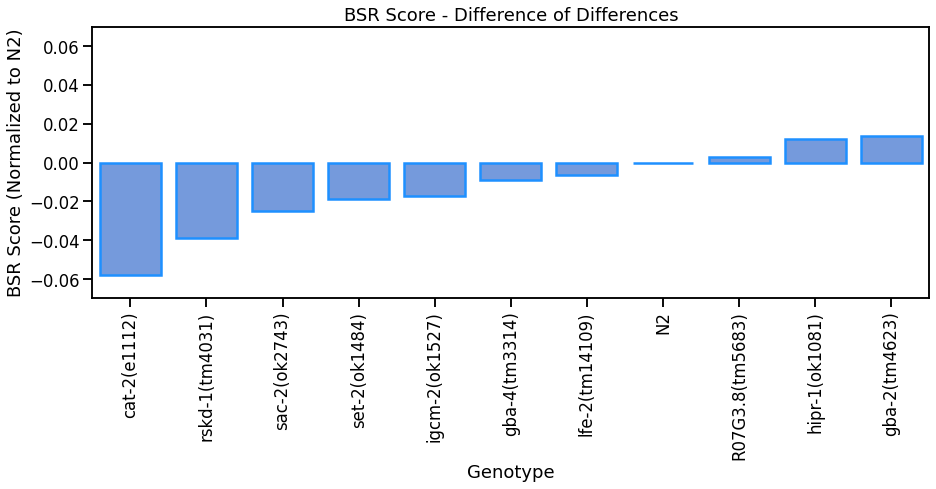

In [16]:
Title = "BSR Score - Difference of Differences"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = 'Genotype', 
             y = 'Score_diff_of_diff', 
             data = speed_diff_sorted,  # <--------------- Input Here -------------
             color = 'CornflowerBlue',
             edgecolor = "DodgerBlue",
             linewidth = 2.5,
#              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
                )
plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel("BSR Score (Normalized to N2)")
# plt.ylim(top = 0.1)
# plt.ylim(bottom = -0.1)
plt.ylim(top = 0.07)
plt.ylim(bottom = -0.07)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')
plt.show()

## Making the bar plot (difference of percent change)

<Figure size 432x288 with 0 Axes>

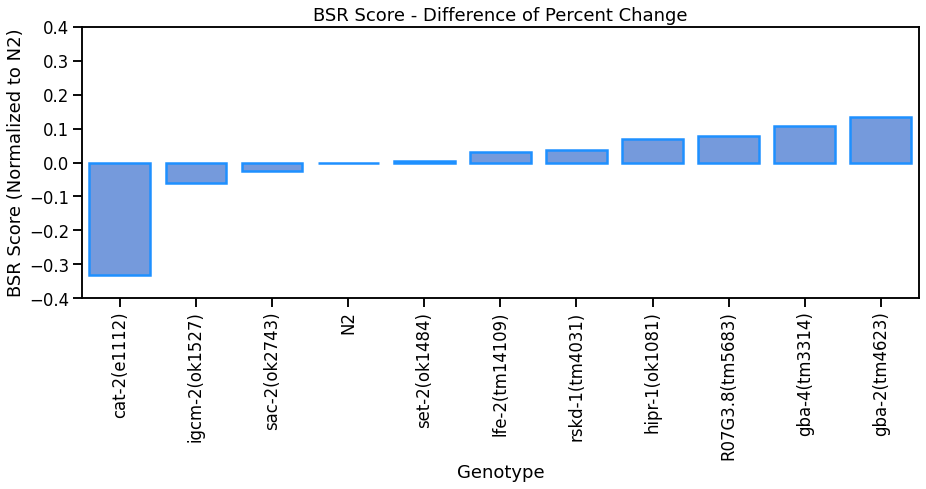

In [17]:
Title = "BSR Score - Difference of Percent Change"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = 'Genotype', 
             y = 'Score_diff_of_pct_diff', 
             data = speed_pct_diff_sorted,  # <--------------- Input Here -------------
             color = 'CornflowerBlue',
             edgecolor = "DodgerBlue",
             linewidth = 2.5,
#              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
                )
plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel("BSR Score (Normalized to N2)")
plt.ylim(top = 0.4)
plt.ylim(bottom = -0.4)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')
plt.show()

# Generic differences of differences script (for any behavioural phenotype)

Very little commentary here, as code is similar to that for BSR score apart from inputting behavioural phenotype of interest

<ipython-input-18-8dd2f6277cdc>:9: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


           Genotype     curve     Score
4      cat-2(e1112)  2.129384 -2.248911
20    set-2(ok1484)  2.676155 -1.702140
18    sac-2(ok2743)  3.418020 -0.960274
2   R07G3.8(tm5683)  3.508874 -0.869421
0                N2  4.378295  0.000000
6     gba-2(tm4623)  4.545092  0.166797
8     gba-4(tm3314)  4.581170  0.202876
12   igcm-2(ok1527)  5.269670  0.891375
14   lfe-2(tm14109)  5.955073  1.576778
10   hipr-1(ok1081)  6.148143  1.769848
16   rskd-1(tm4031)  7.426997  3.048703


<Figure size 432x288 with 0 Axes>

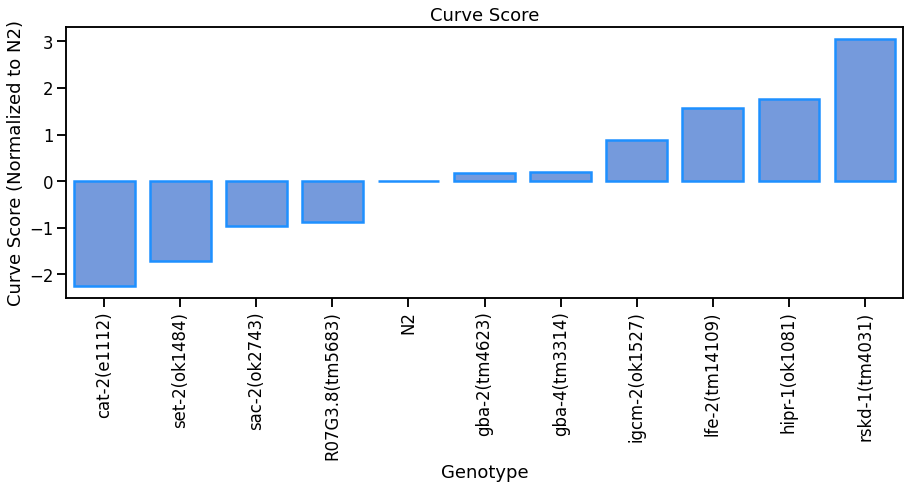

In [18]:
parameter = 'curve'  # <----- INPUT PHENOTYPE OF INTEREST HERE

start = 100 #<----- set the start time of the range
point = 400 #<------- set the end time of your range

chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
chunkeddata_mean = chunkeddata.groupby(["Strain","worm"], as_index=False).mean()
chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)
worm_avg_parameter = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', parameter]]
avg_parameter = worm_avg_parameter.groupby(["Strain", 'Treatment', 'Genotype'], as_index=False).mean()
# print(avg_parameter)

# avg_parameter.to_csv("avg_parameter.csv")

parameter_diff = avg_parameter.drop(columns=["Strain", "Treatment"]).groupby("Genotype", as_index = False).diff(periods = -1).dropna()
parameter_diff.insert(loc = 0, column='Genotype', value = avg_parameter['Genotype'].unique())
parameter_diff.reset_index(drop = True)
# print(parameter_diff)
# print(parameter_diff.iloc[0,1])
parameter_diff['Score'] = parameter_diff[parameter] - parameter_diff.iloc[0,1]
parameter_diff = parameter_diff.sort_values(by = ["Score"])
print(parameter_diff)

#################

# print(parameter_diff.iloc[0,1])

#################

# AGAIN, NOT SURE WHAT THIS IS FOR - BEN
# avg_parameter["new"] = range(1,len(avg_parameter) + 1)
# avg_parameter.loc[avg_parameter.index == 4, 'new'] = 0
# avg_parameter.loc[avg_parameter.index == 4, 'new'] = 0
# print(avg_parameter)
# # avg_parameter.sort_values("new").drop('new', axis=1)

#################

Title = f"{parameter.capitalize()} Score"  # <---------------- Input Here -----------------
sns.set_context("talk")
plt.figure(linewidth = 1)
plt.figure(figsize = (15, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x = "Genotype",
                 y = 'Score',
                 data = parameter_diff,  # <--------------- Input Here -------------
                 color = 'CornflowerBlue',
                 edgecolor = "DodgerBlue",
                 linewidth = 2.5,
                 # seed=5,
                 # ci = 95, # 'sd' for SD, '68' for SEM
                 # palette = ['grey',
                 #            'black'
                 #           ]
                )

plt.xlabel("Genotype")
plt.xticks(rotation = 90)
plt.ylabel(f"{parameter.capitalize()} Score (Normalized to N2)")

# plt.ylim(top = 0.1)
# plt.ylim(bottom = -0.1)
plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

plt.savefig(f'{Title}.jpg', format = 'jpg', dpi = 450, bbox_inches = 'tight')

plt.show()

# Phenotype Heatmap

## Calculate difference of differences scores for all behavioural phenotypes

In [19]:
behavioural_phenotypes = ['speed', 'angularspeed', 'bias', 'curve', 'crab', 'kink']
# print(all_strains)

def differences_of_differences(start, point, df):
    chunkeddata0 = df[df["time"] >= start]
    chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
    chunkeddata_mean = chunkeddata.groupby(["Strain", "worm"], as_index=False).mean()
    chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)
    all_scores = all_strains
    for parameter in behavioural_phenotypes:
        worm_avg_parameter = chunkeddata_mean[['Genotype', 'Treatment', 'Strain', parameter]]
        avg_parameter = worm_avg_parameter.groupby(["Strain", 'Treatment', 'Genotype'], as_index=False).mean()
        # print(avg_parameter)

        # avg_parameter.to_csv("avg_parameter.csv")

        parameter_diff = avg_parameter.drop(columns=["Strain", "Treatment"]).groupby("Genotype", as_index=False).diff(periods=-1).dropna()
        parameter_diff.insert(loc=0, column='Genotype', value = avg_parameter['Genotype'].unique())
        parameter_diff.reset_index(drop=True)
        # print(parameter_diff)
        # print(parameter_diff.iloc[0,1])
        parameter_diff['Score'] = parameter_diff[parameter] - parameter_diff.iloc[0,1]
        # parameter_diff = parameter_diff.sort_values(by = ["Score"])
        parameter_diff = parameter_diff.drop(columns = [parameter])
        parameter_diff = parameter_diff.rename(columns = {'Score':parameter})
        parameter_diff = parameter_diff.reset_index(drop = True)
        # print(parameter_diff)
        all_scores = all_scores.join(parameter_diff.iloc[:,1])
    all_scores = all_scores.set_index("Genotype")
    return(all_scores)

differences_of_differences(100, 400, TotalConcatenated)

<ipython-input-19-bbbe05c132a1>:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


,speed,angularspeed,bias,curve,crab,kink
Genotype,,,,,,
N2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R07G3.8(tm5683),0.002668,-3.329350,0.255768,-0.869421,-0.004915,-5.084235
cat-2(e1112),-0.057929,-5.076337,-0.033952,-2.248911,-0.008036,-3.657612
gba-2(tm4623),0.013613,-1.829588,0.162525,0.166797,-0.002430,-4.266177
gba-4(tm3314),-0.008786,-4.413686,0.292947,0.202876,-0.006536,-1.960113
hipr-1(ok1081),0.012273,2.839423,0.047216,1.769848,0.000962,-1.596524
igcm-2(ok1527),-0.017080,0.974300,-0.034130,0.891375,-0.000866,2.754734
lfe-2(tm14109),-0.006310,-3.984020,0.168133,1.576778,-0.005193,-1.069553
rskd-1(tm4031),-0.038760,-1.746752,0.208881,3.048703,-0.003528,-4.337853


### Use function defined above to store difference of difference dataframe in a new variable

In [20]:
PD_gene_behavioural_scores = differences_of_differences(100, 400, TotalConcatenated)
PD_gene_behavioural_scores = PD_gene_behavioural_scores.dropna().sort_index()
print(PD_gene_behavioural_scores)

                    speed  angularspeed      bias     curve      crab  \
Genotype                                                                
N2               0.000000      0.000000  0.000000  0.000000  0.000000   
R07G3.8(tm5683)  0.002668     -3.329350  0.255768 -0.869421 -0.004915   
cat-2(e1112)    -0.057929     -5.076337 -0.033952 -2.248911 -0.008036   
gba-2(tm4623)    0.013613     -1.829588  0.162525  0.166797 -0.002430   
gba-4(tm3314)   -0.008786     -4.413686  0.292947  0.202876 -0.006536   
hipr-1(ok1081)   0.012273      2.839423  0.047216  1.769848  0.000962   
igcm-2(ok1527)  -0.017080      0.974300 -0.034130  0.891375 -0.000866   
lfe-2(tm14109)  -0.006310     -3.984020  0.168133  1.576778 -0.005193   
rskd-1(tm4031)  -0.038760     -1.746752  0.208881  3.048703 -0.003528   
sac-2(ok2743)   -0.025038     -0.098551 -0.302870 -0.960274 -0.001766   
set-2(ok1484)   -0.018565     -4.370860  0.131982 -1.702140 -0.005824   

                     kink  
Genotype              

<ipython-input-19-bbbe05c132a1>:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split('_', 1, expand=True)


### Normalize and standardize the difference of difference scores

In [21]:
PD_gene_behavioural_scores_standardize = (PD_gene_behavioural_scores - PD_gene_behavioural_scores.mean())/PD_gene_behavioural_scores.std()
print(PD_gene_behavioural_scores_standardize)

PD_gene_behavioural_scores_normalize = PD_gene_behavioural_scores_standardize - PD_gene_behavioural_scores_standardize[PD_gene_behavioural_scores_standardize.index == 'N2'].squeeze()
PD_gene_behavioural_scores_normalize = PD_gene_behavioural_scores_normalize.drop(index = 'N2')
print(PD_gene_behavioural_scores_normalize)

                    speed  angularspeed      bias     curve      crab  \
Genotype                                                                
N2               0.603563      0.741536 -0.478435 -0.107648  1.201162   
R07G3.8(tm5683)  0.726653     -0.549484  1.023017 -0.656533 -0.501745   
cat-2(e1112)    -2.068897     -1.226913 -0.677748 -1.527437 -1.583294   
gba-2(tm4623)    1.231570      0.032078  0.475647 -0.002345  0.359040   
gba-4(tm3314)    0.198243     -0.969957  1.241272  0.020432 -1.063445   
hipr-1(ok1081)   1.169771      1.842577 -0.201259  1.009697  1.534445   
igcm-2(ok1527)  -0.184402      1.119339 -0.678788  0.455098  0.901044   
lfe-2(tm14109)   0.312472     -0.803345  0.508569  0.887808 -0.598185   
rskd-1(tm4031)  -1.184545      0.064199  0.747771  1.817067 -0.021456   
sac-2(ok2743)   -0.551518      0.703321 -2.256394 -0.713891  0.589151   
set-2(ok1484)   -0.252909     -0.953350  0.296348 -1.182248 -0.816718   

                     kink  
Genotype              

## Calculate, standardize, and normalize t-scores for all baseline behavioural and morphological phenotypes

In [22]:
PD_baseline = pd.read_csv('baseline_output.csv')
PD_baseline = PD_baseline.iloc[:, 1:]
PD_baseline = PD_baseline.drop(columns=["x", "y"])
PD_baseline[['Genotype', 'Treatment']] = PD_baseline['Strain'].str.split('_', 1, expand=True)

print(PD_baseline.head())

<ipython-input-22-53ff4d41d44b>:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  PD_baseline[['Genotype', 'Treatment']] = PD_baseline['Strain'].str.split('_', 1, expand=True)


   time_bin  worm   time   speed  angularspeed  pathlength   kink  bias  \
0       4.0   166  3.959  0.1877          9.70     0.02400  49.30   1.0   
1       4.0   242  3.715  0.2145         24.75     0.06700  74.44   1.0   
2       4.0   243  3.803  0.3030         17.75     0.06300  48.25   1.0   
3       4.0   370  3.785  0.2279         32.56     0.05680  19.78   1.0   
4       4.0   462  3.863  0.2375          1.20     0.04565  44.22   1.0   

   curve  dir     crab  length  midline   width  morphwidth     area  \
0  33.80  0.0  0.00420  0.9326    1.055  0.2241     0.16750  0.14870   
1  33.16  0.0  0.04553  0.8833    1.083  0.2542     0.10180  0.11460   
2  31.10  0.0  0.03710  0.8670    1.075  0.2340     0.08795  0.10974   
3  33.97  0.0  0.03903  0.8140    0.973  0.2203     0.23440  0.20390   
4  38.34  0.0  0.00857  0.8057    1.011  0.1313     0.13390  0.11664   

       Strain Genotype Treatment  
0  N2_OffFood       N2   OffFood  
1  N2_OffFood       N2   OffFood  
2  N2_OffFo

In [23]:
PD_baseline_last100 = PD_baseline[((PD_baseline.time <= 420) & (PD_baseline.time >= 320))]
PD_baseline_last100 = PD_baseline_last100.reset_index()
PD_baseline_last100 = PD_baseline_last100.dropna()
print(PD_baseline_last100)

          index  time_bin  worm   time     speed  angularspeed  pathlength  \
0        208005     320.0   374  320.0  0.259800      137.0000      -0.034   
1        208536     321.0     9  320.5  0.238800        8.9450      41.840   
2        208537     321.0    11  320.5  0.246200       18.7300       3.623   
3        208538     321.0    12  320.5  0.270300       31.0000      11.030   
4        208539     321.0    14  320.5  0.250000       28.0500       8.390   
...         ...       ...   ...    ...       ...           ...         ...   
321157  1442153     420.0   102  419.5  0.017470        1.9620       3.875   
321158  1442154     420.0   105  419.5  0.014080        0.7153      17.270   
321159  1442155     420.0   106  419.5  0.007717        0.5615      28.580   
321160  1442156     420.0   107  419.5  0.030330        4.4920       4.984   
321161  1442157     420.0   108  419.5  0.022920        3.0080       7.016   

         kink    bias  curve       dir      crab  length  midli

In [24]:
list = PD_baseline_last100["Genotype"].unique()
print(list)

['N2' 'R07G3.8(tm5683)' 'cat-2(e1112)' 'gba-2(tm4623)' 'gba-4(tm3314)'
 'hipr-1(ok1081)' 'igcm-2(ok1527)' 'lfe-2(tm14109)' 'rskd-1(tm4031)'
 'sac-2(ok2743)' 'set-2(ok1484)']


In [25]:
PD_baseline_last100_OffFood = PD_baseline_last100[PD_baseline_last100["Treatment"] == "OffFood"].dropna().add_suffix('_OffFood')
PD_baseline_last100_OffFood = PD_baseline_last100_OffFood.rename(columns = {'Genotype_OffFood': 'Genotype'})

PD_baseline_last100_OnFood = PD_baseline_last100[PD_baseline_last100["Treatment"] == "OnFood"].dropna().add_suffix('_OnFood')
PD_baseline_last100_OnFood = PD_baseline_last100_OnFood.rename(columns = {'Genotype_OnFood': 'Genotype'})

In [26]:
PD_gene_baseline_length_T = pd.DataFrame(columns = ["Genotype", "length"])
PD_gene_baseline_midline_T = pd.DataFrame(columns = ["Genotype", "midline"])
PD_gene_baseline_width_T = pd.DataFrame(columns = ["Genotype", "width"])
PD_gene_baseline_morphwidth_T = pd.DataFrame(columns = ["Genotype", "morphwidth"])
PD_gene_baseline_area_T = pd.DataFrame(columns = ["Genotype", "area"])

PD_gene_baseline_speed_T_OffFood = pd.DataFrame(columns = ["Genotype", "speed_OffFood"])
PD_gene_baseline_angularspeed_T_OffFood = pd.DataFrame(columns = ["Genotype", "angularspeed_OffFood"])
PD_gene_baseline_bias_T_OffFood = pd.DataFrame(columns = ["Genotype", "bias_OffFood"])
PD_gene_baseline_curve_T_OffFood = pd.DataFrame(columns = ["Genotype", "curve_OffFood"])
PD_gene_baseline_crab_T_OffFood = pd.DataFrame(columns = ["Genotype", "crab_OffFood"])
PD_gene_baseline_kink_T_OffFood = pd.DataFrame(columns = ["Genotype", "kink_OffFood"])

PD_gene_baseline_speed_T_OnFood = pd.DataFrame(columns = ["Genotype", "speed_OnFood"])
PD_gene_baseline_angularspeed_T_OnFood = pd.DataFrame(columns = ["Genotype", "angularspeed_OnFood"])
PD_gene_baseline_bias_T_OnFood = pd.DataFrame(columns = ["Genotype", "bias_OnFood"])
PD_gene_baseline_curve_T_OnFood = pd.DataFrame(columns = ["Genotype", "curve_OnFood"])
PD_gene_baseline_crab_T_OnFood = pd.DataFrame(columns = ["Genotype", "crab_OnFood"])
PD_gene_baseline_kink_T_OnFood = pd.DataFrame(columns = ["Genotype", "kink_OnFood"])

# print(PD_gene_baseline_midline_T)

In [27]:
def TTest_Gene(DatasetList, Type, DF_ref, output):
    for a in DatasetList:
        Tstat = ttest_ind(DF_ref[DF_ref.Genotype == a][Type], DF_ref[DF_ref.Genotype == "N2"][Type], equal_var = False)[0]
        row = [a, Tstat]
        output.loc[len(output)] = row
    print(output)

In [28]:
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "length", PD_baseline_last100, PD_gene_baseline_length_T)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "midline", PD_baseline_last100, PD_gene_baseline_midline_T)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "width", PD_baseline_last100, PD_gene_baseline_width_T)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "morphwidth", PD_baseline_last100, PD_gene_baseline_morphwidth_T)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "area", PD_baseline_last100, PD_gene_baseline_area_T)

TTest_Gene(PD_baseline_last100["Genotype"].unique(), "speed_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_speed_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "angularspeed_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_angularspeed_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "bias_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_bias_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "curve_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_curve_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "crab_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_crab_T_OffFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "kink_OffFood",
           PD_baseline_last100_OffFood, PD_gene_baseline_kink_T_OffFood)

TTest_Gene(PD_baseline_last100["Genotype"].unique(), "speed_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_speed_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "angularspeed_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_angularspeed_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "bias_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_bias_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "curve_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_curve_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "crab_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_crab_T_OnFood)
TTest_Gene(PD_baseline_last100["Genotype"].unique(), "kink_OnFood",
           PD_baseline_last100_OnFood, PD_gene_baseline_kink_T_OnFood)

           Genotype      length
0                N2    0.000000
1   R07G3.8(tm5683)   16.483056
2      cat-2(e1112)  -56.269253
3     gba-2(tm4623)  -53.158078
4     gba-4(tm3314)  -21.875496
5    hipr-1(ok1081)  -90.858139
6    igcm-2(ok1527)  -74.607594
7    lfe-2(tm14109)   54.290409
8    rskd-1(tm4031) -135.587794
9     sac-2(ok2743)  -55.015440
10    set-2(ok1484) -146.529812
           Genotype     midline
0                N2    0.000000
1   R07G3.8(tm5683)  -19.011565
2      cat-2(e1112)  -42.054900
3     gba-2(tm4623)  -95.773314
4     gba-4(tm3314)  -75.423044
5    hipr-1(ok1081) -108.750670
6    igcm-2(ok1527)  -84.087971
7    lfe-2(tm14109)   62.974980
8    rskd-1(tm4031) -177.199850
9     sac-2(ok2743)  -39.036855
10    set-2(ok1484) -260.012825
           Genotype      width
0                N2   0.000000
1   R07G3.8(tm5683) -45.286536
2      cat-2(e1112)  40.429079
3     gba-2(tm4623) -37.197459
4     gba-4(tm3314) -75.318120
5    hipr-1(ok1081)   9.065174
6    igcm-2(ok1

In [29]:
PD_gene_baseline_Tstats = PD_gene_baseline_length_T
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_midline_T.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_width_T.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_morphwidth_T.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_area_T.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_speed_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T_OffFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T_OffFood.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_speed_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_angularspeed_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_bias_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_curve_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_crab_T_OnFood.iloc[:,1])
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.join(PD_gene_baseline_kink_T_OnFood.iloc[:,1])

PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.set_index("Genotype")
print(PD_gene_baseline_Tstats)

                     length     midline      width  morphwidth        area  \
Genotype                                                                     
N2                 0.000000    0.000000   0.000000    0.000000    0.000000   
R07G3.8(tm5683)   16.483056  -19.011565 -45.286536  -23.672209   -8.875923   
cat-2(e1112)     -56.269253  -42.054900  40.429079   15.231186  -32.520982   
gba-2(tm4623)    -53.158078  -95.773314 -37.197459  -91.309138 -161.265268   
gba-4(tm3314)    -21.875496  -75.423044 -75.318120  -79.190786 -123.175722   
hipr-1(ok1081)   -90.858139 -108.750670   9.065174  -24.302509 -109.904018   
igcm-2(ok1527)   -74.607594  -84.087971  16.834926   14.071444  -62.311014   
lfe-2(tm14109)    54.290409   62.974980   0.023915   18.130469   49.468157   
rskd-1(tm4031)  -135.587794 -177.199850 -38.244528  -52.170800 -153.794442   
sac-2(ok2743)    -55.015440  -39.036855  30.651788   25.031645  -18.219690   
set-2(ok1484)   -146.529812 -260.012825 -98.528556 -139.962875 -

In [30]:
PD_gene_baseline_Tstats = PD_gene_baseline_Tstats.dropna().sort_index()

PD_gene_baseline_Tstats_standardize = (PD_gene_baseline_Tstats - PD_gene_baseline_Tstats.mean())/PD_gene_baseline_Tstats.std()
print(PD_gene_baseline_Tstats_standardize)

PD_gene_baseline_Tstats_normalize = PD_gene_baseline_Tstats_standardize - PD_gene_baseline_Tstats_standardize[PD_gene_baseline_Tstats_standardize.index == 'N2'].squeeze()
PD_gene_baseline_Tstats_normalize = PD_gene_baseline_Tstats_normalize.drop(index = 'N2')
print(PD_gene_baseline_Tstats_normalize)

                   length   midline     width  morphwidth      area  \
Genotype                                                              
N2               0.835269  0.871469  0.404985    0.570228  0.891459   
R07G3.8(tm5683)  1.104205  0.654087 -0.616140    0.131113  0.791848   
cat-2(e1112)    -0.082816  0.390605  1.316582    0.852765  0.526486   
gba-2(tm4623)   -0.032054 -0.223622 -0.433746   -1.123543 -0.918372   
gba-4(tm3314)    0.478350  0.009067 -1.293294   -0.898749 -0.490904   
hipr-1(ok1081)  -0.647166 -0.372008  0.609387    0.119421 -0.341960   
igcm-2(ok1527)  -0.382023 -0.090010  0.784580    0.831252  0.192162   
lfe-2(tm14109)   1.721067  1.591537  0.405524    0.906546  1.446625   
rskd-1(tm4031)  -1.376971 -1.154669 -0.457356   -0.397532 -0.834529   
sac-2(ok2743)   -0.062359  0.425114  1.096123    1.034562  0.686985   
set-2(ok1484)   -1.555500 -2.101568 -1.816645   -2.026062 -1.949800   

                 speed_OffFood  angularspeed_OffFood  bias_OffFood  \
Genoty

In [31]:
full_heatmap = PD_gene_baseline_Tstats_normalize.join(PD_gene_behavioural_scores_normalize)
print(full_heatmap)

                   length   midline     width  morphwidth      area  \
Genotype                                                              
R07G3.8(tm5683)  0.268936 -0.217382 -1.021124   -0.439116 -0.099612   
cat-2(e1112)    -0.918085 -0.480864  0.911598    0.282536 -0.364973   
gba-2(tm4623)   -0.867323 -1.095091 -0.838731   -1.693771 -1.809831   
gba-4(tm3314)   -0.356919 -0.862402 -1.698278   -1.468977 -1.382364   
hipr-1(ok1081)  -1.482434 -1.243476  0.204402   -0.450808 -1.233419   
igcm-2(ok1527)  -1.217292 -0.961478  0.379595    0.261023 -0.699298   
lfe-2(tm14109)   0.885798  0.720068  0.000539    0.336318  0.555166   
rskd-1(tm4031)  -2.212240 -2.026137 -0.862340   -0.967761 -1.725988   
sac-2(ok2743)   -0.897628 -0.446355  0.691139    0.464333 -0.204474   
set-2(ok1484)   -2.390769 -2.973037 -2.221629   -2.596291 -2.841260   

                 speed_OffFood  angularspeed_OffFood  bias_OffFood  \
Genotype                                                             
R07G3.8

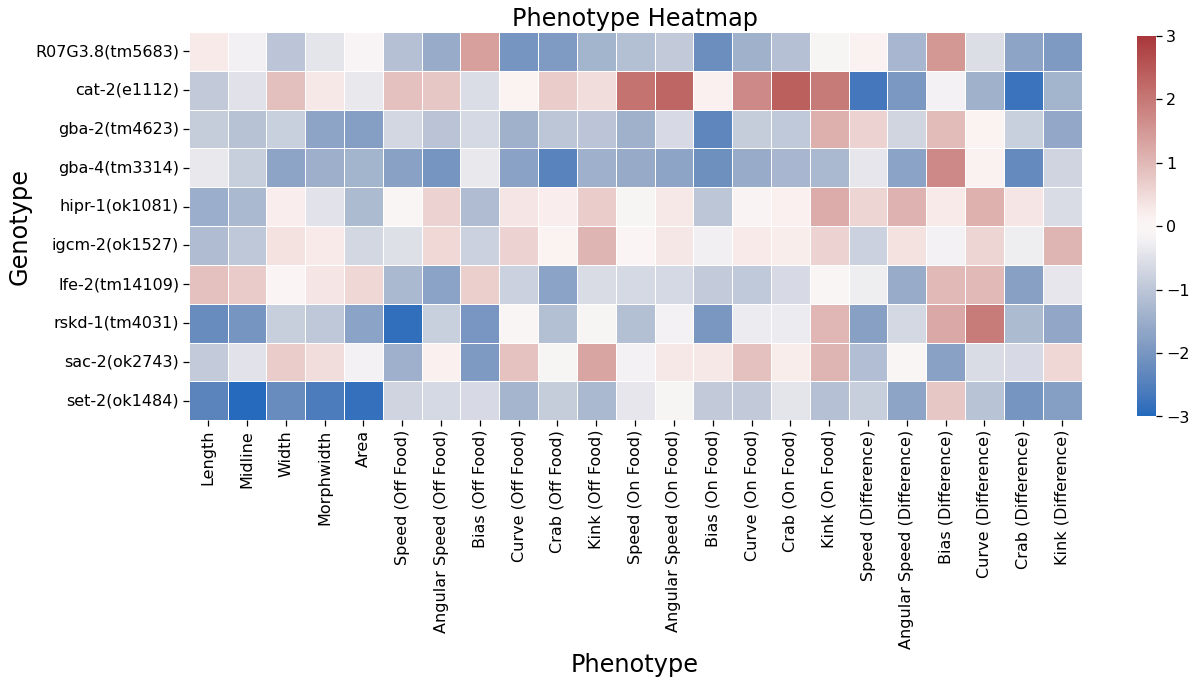

In [32]:
sns.set_context('notebook')
plt.figure(figsize = (20,14))
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16) 
ax = sns.heatmap(data = full_heatmap, 
                 annot = False, 
                 linewidth = 0.5, 
                 square = True, 
                 cmap = "vlag", 
                 center = 0, 
                 vmax = 3,
                 vmin = -3, 
                 # xticklabels = 1,
                 xticklabels = ['Length', 'Midline', 'Width', 'Morphwidth', 'Area',
                                'Speed (Off Food)', 'Angular Speed (Off Food)', 'Bias (Off Food)',
                                'Curve (Off Food)', 'Crab (Off Food)', 'Kink (Off Food)',
                                'Speed (On Food)', 'Angular Speed (On Food)', 'Bias (On Food)',
                                'Curve (On Food)', 'Crab (On Food)', 'Kink (On Food)',
                                'Speed (Difference)', 'Angular Speed (Difference)', 'Bias (Difference)',
                                'Curve (Difference)', 'Crab (Difference)', 'Kink (Difference)'],
                 yticklabels = 1,
                 cbar_kws = {"shrink": .5,
                             # "label": "Normalized Behaviour Score"
                            })
ax.set_ylabel('Genotype', fontsize = 24)
ax.set_xlabel('Phenotype', fontsize = 24)
ax.set_title('Phenotype Heatmap', fontsize = 24)
# plt.savefig('BehaviourScore_GENE_normalized2_square.jpg', format='jpg', dpi=450, bbox_inches = "tight")
plt.savefig('Complete_GENE_heatmap_normalized_square.jpg', format = 'jpg', dpi = 450, bbox_inches = "tight")
plt.show()

# Everything below not intended for large scale analysis of many strains, and include bugs that would need to be fixed (commented out so notebook can be run start to finish)

# 8.3 Graphing Bar Graphs

# Speed Barplots Comparison

In [33]:
# # Valid Measurement inputs(change var)
# # 1:'speed', <---
# # 2: "x",
# # 3: "y",
# # 4: "angularspeed", <-----
# # 5: "pathlength",
# # 6: "kink",  <---
# # 7: "bias", <----
# # 8: "curve", <---
# # 9: "dir",<----
# # 10: "crab",<----
# # 11: "length",<---
# # 12: "midline",<----
# # 13: "width",<----
# # 14: "morphwidth",<----
# # 15: "area"<----

# start = 200
# point = 400
# var = "area"
# chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= start]
# chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]
# chunkeddata_mean = chunkeddata.groupby(["Strain","worm"], as_index=False).mean()
# chunkeddata_mean[['Genotype', 'Treatment']] = chunkeddata_mean['Strain'].str.split(' - ', 1, expand=True)

# Title = f"{var} - {start}-{point} seconds" #<---------------- Input Here -----------------
# sns.set_context("talk")
# plt.figure(linewidth = 2.5)
# plt.figure(figsize=(15, 3))
# plt.gca().xaxis.grid(False)
# ax = sns.barplot(x="Genotype", 
#              y = var, 
#              data = chunkeddata_mean, #<--------------- Input Here -------------
#              hue = 'Treatment',
#              edgecolor="black",
#              linewidth = 2.5,
# #              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
#                 )
# plt.xlabel("Strain and Condition")
# # plt.ylabel("Average Speed (mm/s)")
# plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
# plt.savefig(f'{Title}.png', format='png', dpi=450, bbox_inches = 'tight')
# plt.show()

In [34]:
# Test Cell
# chunkeddata_mean

In [35]:
# Test Cell
# TotalConcatenated.describe()
# chunkeddata0
# chunkeddata

# Bias Barplots Comparison

In [36]:
# point = 420
# var = "bias"
# chunkeddata0 = TotalConcatenated[TotalConcatenated["time"] >= 0]
# chunkeddata = chunkeddata0[chunkeddata0["time"] <= point]

# Title = f"{var} - First {point} seconds" #<---------------- Input Here -----------------
# sns.set_context("talk")
# plt.figure(linewidth = 2.5)
# plt.figure(figsize=(15, 5))
# plt.gca().xaxis.grid(False)
# ax = sns.barplot(x="Genotype", 
#              y = var, 
#              data = chunkeddata, #<--------------- Input Here -------------
#              hue = 'Treatment',
#              edgecolor="black",
#              linewidth = 2.5,
#              ci = None,
#              palette = ['black',
#                         'grey'
#                        ]
#                 )
# plt.xlabel("Strain and Condition")
# # plt.ylabel("Average Speed (mm/s)")
# plt.title(Title)
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
# # plt.savefig(f'{Title}.png', format='png', dpi=450, bbox_inches = 'tight')
# plt.show()